In [ ]:
import pandas as pd
import numpy as np
from scipy import stats

In [ ]:
municipio = 47 #Collado Villalba
magnitud = 7 #Monóxido de Nitrógeno
madridDataMesActual = pd.read_csv('calidad_aire_datos_mes.csv',sep=';')

In [ ]:
municipioDataMesActual = madridDataMesActual[madridDataMesActual['municipio']==municipio]
municipioDataMesActual = municipioDataMesActual[municipioDataMesActual['magnitud']==magnitud]
municipioDataMesActual.drop(['provincia','municipio','estacion','punto_muestreo'], axis=1, inplace=True)

In [ ]:
municipioDataMesActual.dtypes

,0
magnitud,int64
ano,int64
mes,int64
dia,int64
h01,object
v01,object
h02,object
v02,object
h03,object
v03,object


Observamos que los valores de las mediciones son de tipo object en lugar de float. Por lo que vamos a convertirlos

In [ ]:
for i in range(1,25):
  if i < 10:
    measureIndex = 'h0'+ str(i)
  else:
    measureIndex = 'h'+ str(i)
  municipioDataMesActual[measureIndex] = municipioDataMesActual[measureIndex].str.replace(',','.').astype(float)

In [ ]:
for i in municipioDataMesActual.index:
  municipioDataMesActual.loc[i,'dt'] = str(municipioDataMesActual.loc[i,'dia']) + '-' + str(municipioDataMesActual.loc[i,'mes']) + '-' + str(municipioDataMesActual.loc[i,'ano'])
municipioDataMesActual['dt'] = pd.to_datetime(municipioDataMesActual['dt'],format='%d-%m-%Y')
municipioDataMesActual.drop(['dia','mes','ano'], axis=1, inplace=True)

Ahora ya tenemos un campo con la fecha en la que se llevó a cabo la medición.

El problema es que a nosotros nos interesa tener una serie temporal en la que cada elemento de la misma represente la medición que se llevo a cabo en una hora concreta. Actualmente en nuestro dataset, por cada registro se recogen los 24 valores tomados cada hora del dia en diferentes columnas (h1, h2, h3...)

A continuación generaremos un nuevo dataset en el que por cada registro del original se crearán 24 registros del nuevo, uno para cada una de las mediciones y su respectiva validación. En concreto el siguiente código lo que hace es crear el mencionado dataset añadiendo una nueva columna 'hora' que contendrá el la hora en la que se llevó acabo la medición.

In [ ]:
new_rows = []
for index, row in municipioDataMesActual.iterrows():
  for hour in range(1, 25):
    if hour < 10:
      measureIndex = 'h0' + str(hour)
      validacionIndex = 'v0' + str(hour)
    else:
      measureIndex = 'h' + str(hour)
      validacionIndex = 'v' + str(hour)
    new_row = row.copy()
    new_row['hora'] = hour
    new_row['valor'] = new_row[measureIndex]
    new_row['validacion'] = new_row[validacionIndex]
    new_rows.append(new_row)

municipioDataMesActualTimeseries = pd.DataFrame(new_rows)
for i in range(1, 25):
  if i < 10:
    measureIndex = 'h0' + str(i)
    validacionIndex = 'v0' + str(i)
  else:
    measureIndex = 'h' + str(i)
    validacionIndex = 'v' + str(i)
  municipioDataMesActualTimeseries.drop(measureIndex, axis=1, inplace=True)
  municipioDataMesActualTimeseries.drop(validacionIndex, axis=1, inplace=True)
municipioDataMesActualTimeseries

,magnitud,dt,hora,valor,validacion
90,7,2024-09-01,1,1.0,V
90,7,2024-09-01,2,1.0,V
90,7,2024-09-01,3,1.0,V
90,7,2024-09-01,4,1.0,V
90,7,2024-09-01,5,1.0,V
...,...,...,...,...,...
4279,7,2024-09-25,20,1.0,V
4279,7,2024-09-25,21,1.0,V
4279,7,2024-09-25,22,1.0,V
4279,7,2024-09-25,23,1.0,V


El siguiente paso será modificar la estructura de cada una de las filas, añadiendo al atributo 'dt' el valor de la hora a la que se realizó la medición. Para ello, hay que tener en cuenta que si el valor del atributo 'hora' es igual a 24 habrá que incrementar el valor del atributo 'dt' en un dia, pues en realidad se tomó a las 00:00 del día siguiente.

In [ ]:
municipioDataMesActualTimeseries['updatedDT'] = municipioDataMesActualTimeseries.apply(lambda row: row['dt'] + pd.Timedelta(days=1) if row['hora'] == 24 else row['dt'], axis=1)
municipioDataMesActualTimeseries['dt'] = municipioDataMesActualTimeseries['updatedDT'] + pd.to_timedelta(municipioDataMesActualTimeseries['hora'] % 24, unit='h')
municipioDataMesActualTimeseries.drop(['hora','updatedDT'], axis=1, inplace=True)

De esta forma, si imprimimos el contenido de nuestra serie temporal obtendríamos un conjunto de datos con el siguiente formato:

In [ ]:
municipioDataMesActualTimeseries.set_index('dt', inplace=True)
municipioDataMesActualTimeseries

,magnitud,valor,validacion
dt,,,
2024-09-01 01:00:00,7,1.0,V
2024-09-01 02:00:00,7,1.0,V
2024-09-01 03:00:00,7,1.0,V
2024-09-01 04:00:00,7,1.0,V
2024-09-01 05:00:00,7,1.0,V
...,...,...,...
2024-09-25 20:00:00,7,1.0,V
2024-09-25 21:00:00,7,1.0,V
2024-09-25 22:00:00,7,1.0,V


Podemos observar la evolución de la concentración de monóxido de carbono en el aire durante el mes de Septiembre graficando el contenido del atributo 'valor'

<Axes: xlabel='dt'>

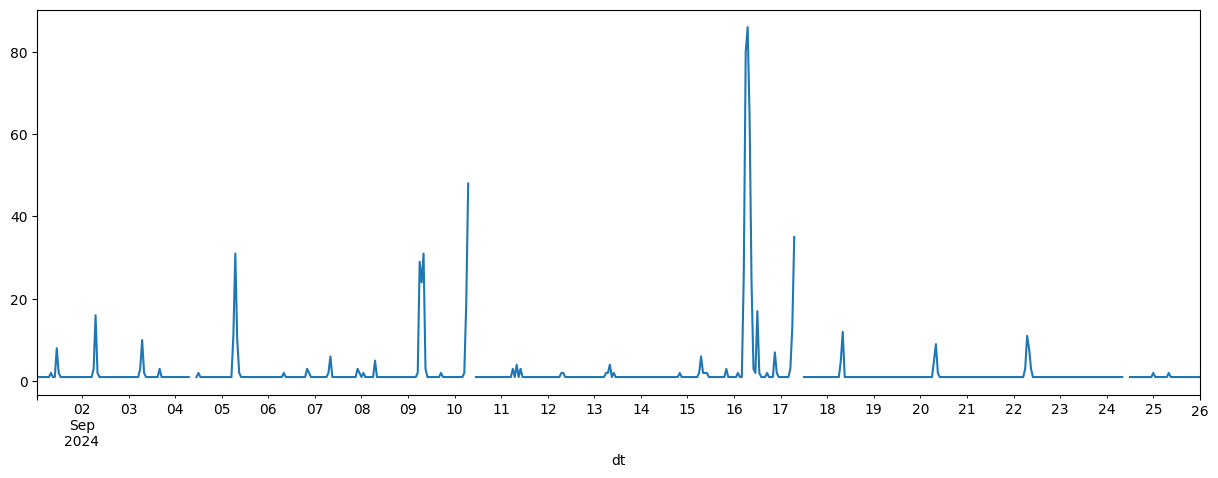

In [ ]:
municipioDataMesActualTimeseries['valor'].plot(figsize=(15,5))

A continuación vamos a crear una función que reciba un dataset con el mismo formato que el fichero con el que hemos trabajado, y realice toda esta transformación. De esta manera le podremos pasar los datasets de los años con los que pretendemos trabajar y nos devolverá los datos con el formato buscado

In [ ]:
def process_air_quality_data(csv_file_path):
  madridDataMesActual = pd.read_csv(csv_file_path, sep=';')
  municipioDataMesActual = madridDataMesActual[madridDataMesActual['municipio'] == municipio]
  municipioDataMesActual = municipioDataMesActual[municipioDataMesActual['magnitud'] == magnitud]
  municipioDataMesActual.drop(['provincia', 'municipio', 'estacion', 'punto_muestreo'], axis=1, inplace=True)
  for i in range(1, 25):
    if i < 10:
      measureIndex = 'h0' + str(i)
    else:
      measureIndex = 'h' + str(i)
    municipioDataMesActual[measureIndex] = municipioDataMesActual[measureIndex].str.replace(',', '.').astype(float)
  for i in municipioDataMesActual.index:
    municipioDataMesActual.loc[i, 'dt'] = str(municipioDataMesActual.loc[i, 'dia']) + '-' + str(municipioDataMesActual.loc[i, 'mes']) + '-' + str(municipioDataMesActual.loc[i, 'ano'])

  municipioDataMesActual['dt'] = pd.to_datetime(municipioDataMesActual['dt'], format='%d-%m-%Y')
  municipioDataMesActual.drop(['dia', 'mes', 'ano'], axis=1, inplace=True)
  new_rows = []
  for index, row in municipioDataMesActual.iterrows():
    for hour in range(1, 25):
      if hour < 10:
        measureIndex = 'h0' + str(hour)
        validacionIndex = 'v0' + str(hour)
      else:
        measureIndex = 'h' + str(hour)
        validacionIndex = 'v' + str(hour)
      new_row = row.copy()
      new_row['hora'] = hour
      new_row['valor'] = new_row[measureIndex]
      new_row['validacion'] = new_row[validacionIndex]
      new_rows.append(new_row)
  municipioDataMesActualTimeseries = pd.DataFrame(new_rows)
  for i in range(1, 25):
    if i < 10:
      measureIndex = 'h0' + str(i)
      validacionIndex = 'v0' + str(i)
    else:
      measureIndex = 'h' + str(i)
      validacionIndex = 'v' + str(i)
    municipioDataMesActualTimeseries.drop(measureIndex, axis=1, inplace=True)
    municipioDataMesActualTimeseries.drop(validacionIndex, axis=1, inplace=True)
  municipioDataMesActualTimeseries['updatedDT'] = municipioDataMesActualTimeseries.apply(lambda row: row['dt'] + pd.Timedelta(days=1) if row['hora'] == 24 else row['dt'], axis=1)
  municipioDataMesActualTimeseries['dt'] = municipioDataMesActualTimeseries['updatedDT'] + pd.to_timedelta(municipioDataMesActualTimeseries['hora'] % 24, unit='h')
  municipioDataMesActualTimeseries.drop(['hora', 'updatedDT'], axis=1, inplace=True)
  municipioDataMesActualTimeseries.set_index('dt', inplace=True)

  return municipioDataMesActualTimeseries


Una vez definida la función de transformación la llamamos para los datos de 2021, 2022, 2023 y los meses anteriores de 2024. Si se transforman con éxito serán añadidos a la lista 'dataframes'

In [ ]:

dataframes = []

try:
  df_2024 = process_air_quality_data('2024.csv')
  dataframes.append(df_2024)
except Exception as e:
  print(e)

try:
  df_2023 = process_air_quality_data('2023.csv')
  dataframes.append(df_2023)
except Exception as e:
  print(e)

try:
  df_2022 = process_air_quality_data('2022.csv')
  dataframes.append(df_2022)
except Exception as e:
  print(e)

try:
  df_2021 = process_air_quality_data('2021.csv')
  dataframes.append(df_2021)
except Exception as e:
  print(e)

Una vez transformados los dataframes, procedemos a concatenarlos con el dataset que contiene la información relativa al mes actual, para posteriormente graficar los resultados y obtener una serie temporal de la siguiente forma:

<Axes: xlabel='dt'>

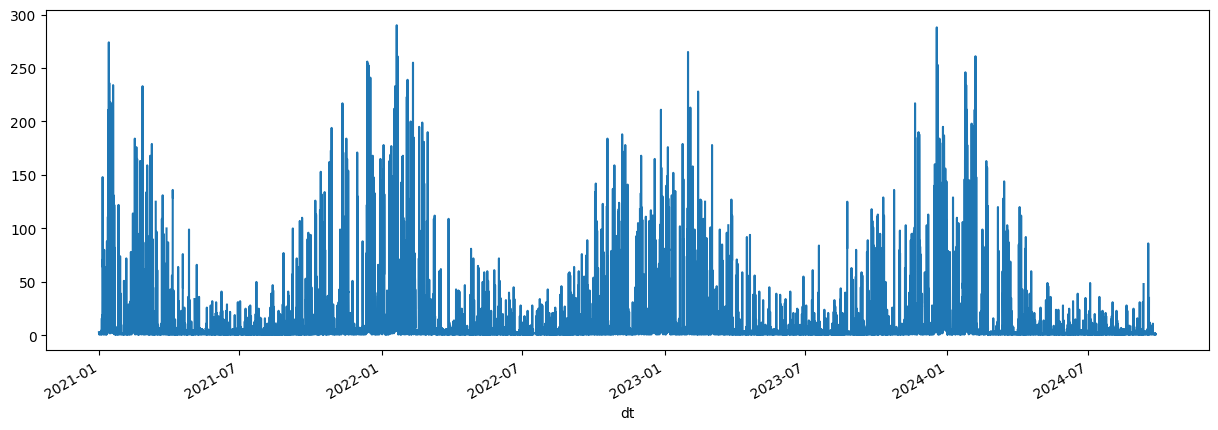

In [ ]:
dataframes.append(municipioDataMesActualTimeseries)

combined_df = pd.concat(dataframes, axis=0)
combined_df['valor'].plot(figsize=(15, 5))

In [ ]:
print(len(combined_df))

32736
